# Jupiter notebook for the seventh seminar

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8,5
%matplotlib inline

## Pre-implemented ensembles: Gradient Boosting

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier, plot_tree

In [ ]:
def plot_decision_surface(clf, X, y, nx=200, ny=100, cmap='bwr', alpha=0.6):
    """
    Plot the decision boundary of clf on X and y, visualize training points
    """
    
    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.linspace(x_top_left[0], x_bottom_right[0], ny),
         np.linspace(x_top_left[1], x_bottom_right[1], nx)
        )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    plt.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    plt.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    plt.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    plt.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    
    plt.legend(loc='best')

In [ ]:
!wget https://github.com/HSE-LAMBDA/MLatFIAN2021/raw/main/seminar06/data.npz

--2021-11-18 22:07:38--  https://github.com/HSE-LAMBDA/MLatFIAN2021/raw/main/seminar06/data.npz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2021/main/seminar06/data.npz [following]
--2021-11-18 22:07:39--  https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2021/main/seminar06/data.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108474 (106K) [application/octet-stream]
Saving to: ‘data.npz.2’

data.npz.2          100%[===================>] 105.93K  --.-KB/s    in 0.003s  

2021-11-18 22:07:39 (30.2 MB/s) - ‘data.npz.2’ saved [108474/108474]



In [ ]:
data = np.load('data.npz')
X, y = data["X"], data["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1337)

print("Shape of data:", X.shape)

Shape of data: (4505, 2)


We now investigate how decision surface depends on the number of trees:

n_estimators = 1


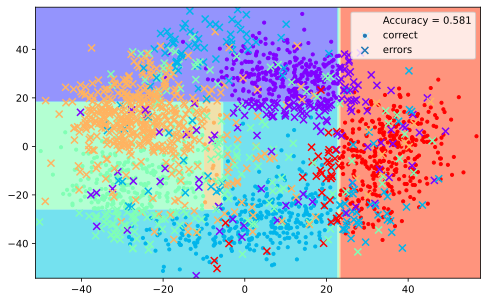

n_estimators = 2


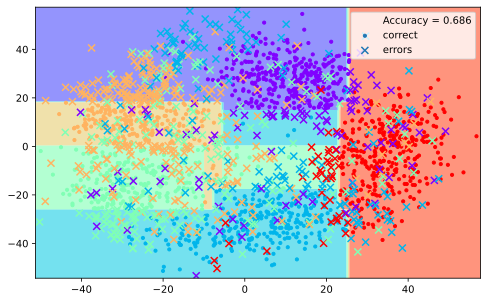

n_estimators = 3


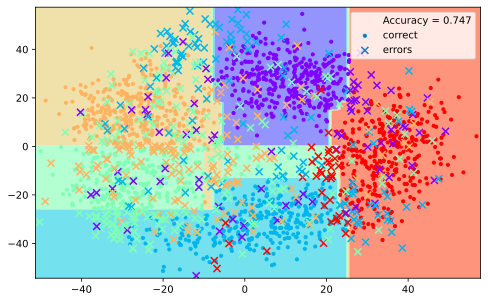

n_estimators = 4


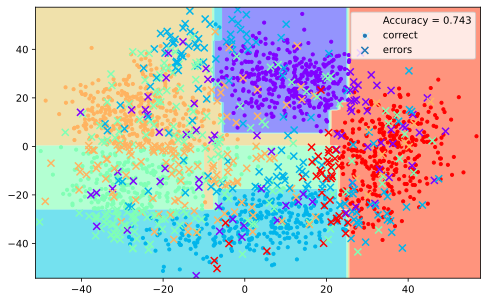

n_estimators = 5


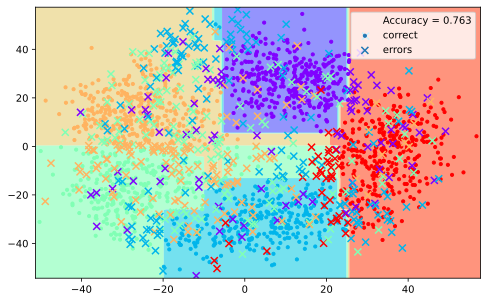

n_estimators = 6


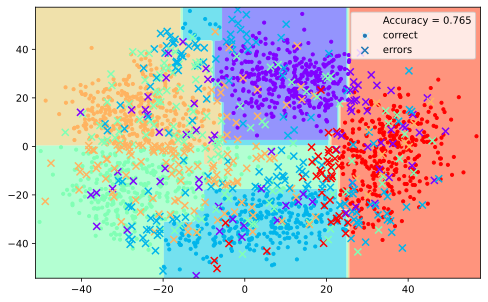

n_estimators = 7


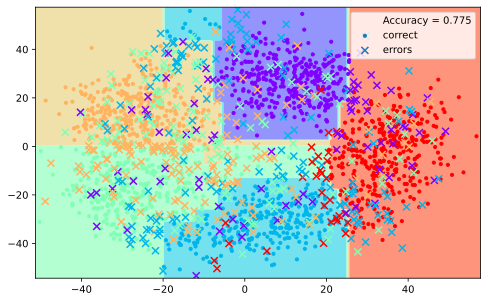

n_estimators = 8


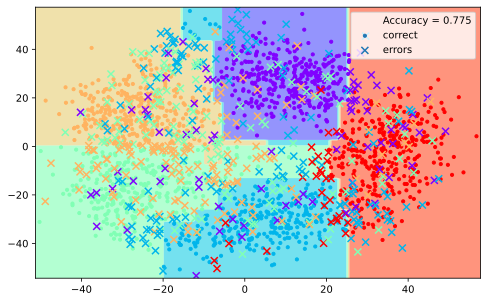

n_estimators = 9


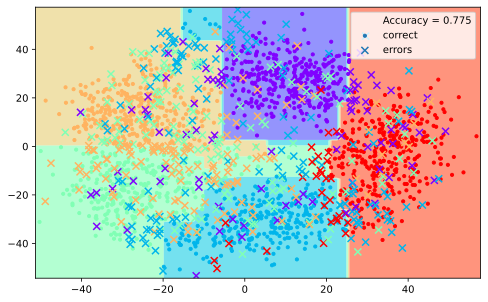

In [ ]:
for n_estimators in range(1,10):
    model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss",
                          n_estimators=n_estimators, max_depth=1, learning_rate=0.5)

    model.fit(X_train, y_train)

    print("n_estimators =", n_estimators)
    plt.figure(figsize=(8, 5))
    plot_decision_surface(model, X_test, y_test, cmap='rainbow')
    plt.show()

Let's use plot_tree function:

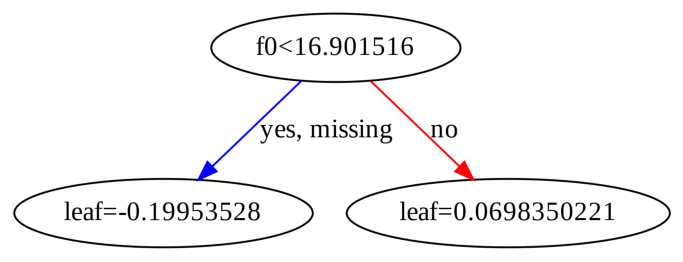

In [ ]:
fig, ax = plt.subplots(figsize=(12, 9))
plot_tree(model, num_trees=44, ax=ax, dpi='400');

Now we adjust the parameters to improve the score:

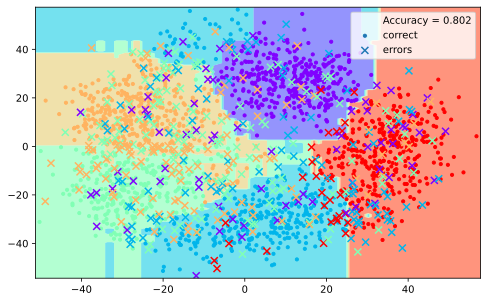

In [ ]:
model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss",
                      n_estimators=15, max_depth=6, learning_rate=0.5,
                      reg_lambda=10, min_child_weight=10)

model.fit(X_train, y_train)

plt.figure(figsize=(8, 5))
plot_decision_surface(model, X_test, y_test, cmap='rainbow')
plt.show();

## Example: maximum likelihood fit

We create a Gaussian mixture dataset and then fit its parameters with maximum likelihood:

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from math import pi

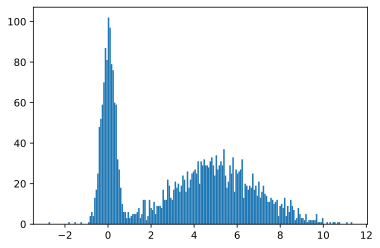

In [ ]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

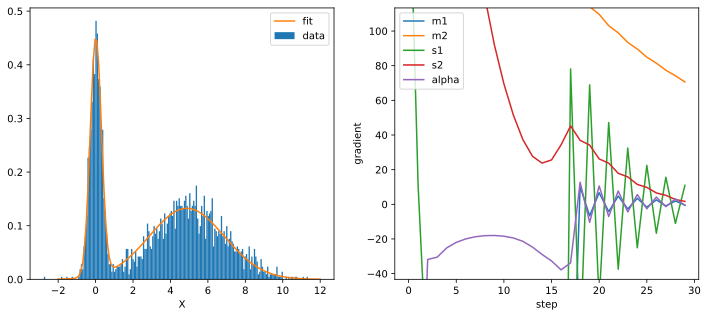

In [20]:
from IPython.display import clear_output

# Defining Gaussian PDF using tf functions
def gaussian(x, mu, sigma):
  return (1./(tf.sqrt(2*pi)*sigma)) * tf.exp(-((x-mu)**2)/(2.*sigma**2))

# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
  return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1    = tf.Variable(1.0)
m2    = tf.Variable(4.0)
s1    = tf.Variable(1.0)
s2    = tf.Variable(1.0)
alpha = tf.Variable(0.5)

# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
  # ensure the sigmas are positive (greater or equal to some small
  # positive number, e.g. 1e-5) and alpha is in (0, 1) interval
  # hint: use the `assign` method to update the variable values
  if (s1 <= 1e-5):
    s1.assign(0.01)
  if (s2 <= 1e-5):
    s2.assign(0.01)
  if (alpha <= 1e-5):
    alpha.assign(0.01)
  else:
    if (alpha >= 1):
      alpha.assign(0.99)


variables = [m1, m2, s1, s2, alpha]

# Defining the overall PDF
def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)

# Log likelihood
def loglike(x):
  # hint: the logarithm is in tf.math.log
  return tf.reduce_sum(tf.math.log(model_pdf(x)))

learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps

for i in range(30):
  with tf.GradientTape() as t:
    # NOTE: if `variable` was created with `trainable=False`, you need to
    # manually add it to the tape by calling `t.watch(variable)`. By default
    # the variable are created with `trainable=True`
    t.watch(variables)

    # Forward pass:
    l = loglike(X)
  
  # Backprop:
  grads = t.gradient(l, variables) # Calculate the gradients
  grad_history.append([g.numpy() for g in grads])

  # Gradient ascent step:
  # Apply the gradients manually (add
  # `learning_rate * corresponding_gradient` to
  # each variable)
  for j, v in enumerate(variables):
    v.assign(v+grad_history[i][j]*learning_rate)
  apply_constraints()

  ############################
  # Do some plotting
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.hist(X, bins=200, density=True, label='data')
  x_grid = np.linspace(-2, 12, 150)
  plt.plot(x_grid, model_pdf(x_grid), label='fit')
  plt.legend()
  plt.xlabel('X')

  plt.subplot(1, 2, 2)
  lines = plt.plot(np.array(grad_history))
  low = min(grad_history[-1])
  high = max(grad_history[-1])
  plt.ylim(low  - (high - low) * 0.6,
           high + (high - low) * 0.6)
  plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
  plt.xlabel('step')
  plt.ylabel('gradient')
  plt.show()
  clear_output(wait=True);